# Titanic: Machine Learning from Disaster

## Introduction
Titanic is a famous ship that sank on 15 April 1912 after colliding with an iceberg. 
There were 2224 passengers and 1502 died making it one of the deadliest disaster of the modern history. <sup>[1]</sup>

Our job here is to build a model that answers how likely people were to survive this disaster. <br />
The process we'll be as following:
1. Data Exploration and Visualization
2. Feature Engineering

## Source
1. https://en.wikipedia.org/wiki/RMS_Titanic

In [1]:
# from math stuff
import numpy as np
# for handling the dataset
import pandas as pd
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier

sns.set(style="white", context="talk")
%matplotlib inline

## Data Exploration and Visualization
First of all, let's load and explore the dataset.

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print('train size: {0}; test size: {1}'.format(len(train), len(test)))

train size: 891; test size: 418


We have a training set with 891 samples and a testing set with 418 samples. <br />
Let's take a preview on training set.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here, we can see that our response variable (label) is **Survived** and it's a categorical variable. <br />
This means that we'll be using a classifier as prediction model.

The other ones are explanatory variables and there are categorical and continuous variables.

We can see the feature **Cabin** has NaN values. This is a problem the should be handled. <br />
Let's take an overview on dataset and see the quantity of NaN values.

In [4]:
print('***TRAINING SET***')
print(train.isnull().sum())
print('\n***TESTING SET***')
print(test.isnull().sum())

***TRAINING SET***
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

***TESTING SET***
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Now we can see that:
* The feature **Cabin** might be discarded since more than 70% of the data isn't provided.
* The feature **Embarked** has only 2 samples with NaN. We could discard the sample or impute values.
* The feature **Age** has 263 samples with NaN. This is about 20% of the data. Discarding the feature might be pretty much loss of information. So, we should be imputing new values.

Now, let's plot some graphs in order to get some insight about the dataset. <br />
Our response variable is **Survived**, so let's see the ratio between the Survived and Desceased people.

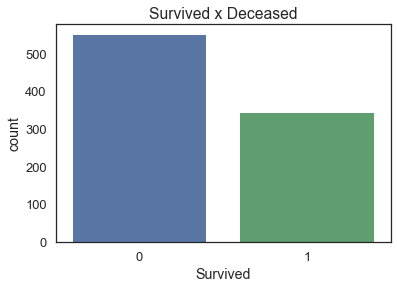

In [5]:
plt.title('Survived x Deceased')
sns.countplot(data=train, x='Survived')

Here we can see that most of the people desceased, but nothing more. <br />
Let's see the survivability rate between genders.

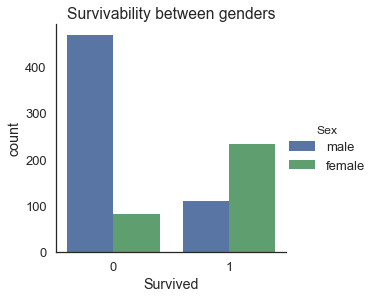

In [6]:
sns.factorplot(data=train, x='Survived', hue='Sex', kind='count')
plt.title('Survivability between genders')

Now, we have an interesting insight. Most of the men died on this disaster. <br />
This is due to the "women and children first" protocol while loading the safeboats.

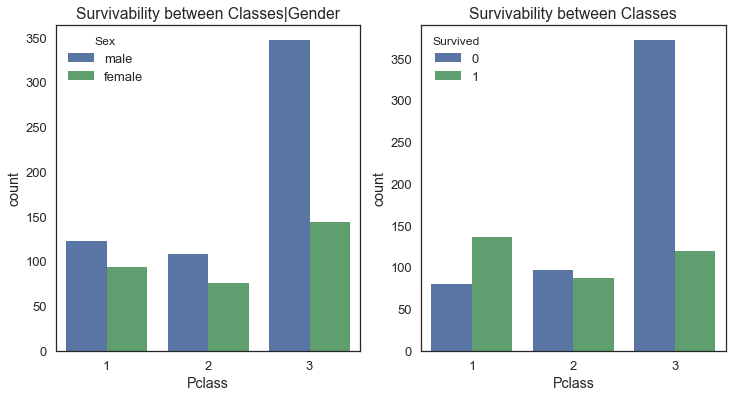

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(data=train, x='Pclass', hue='Sex', ax=ax1)
ax1.set_title('Survivability between Classes|Gender')

sns.countplot(data=train, x='Pclass', hue='Survived', ax=ax2)
ax2.set_title('Survivability between Classes')

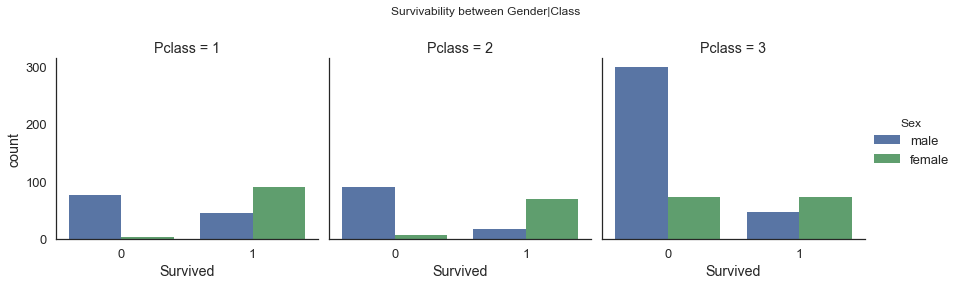

In [41]:
ax = sns.factorplot(data=train, x='Survived', hue='Sex', col='Pclass', kind='count')
ax.fig.subplots_adjust(top=.8)
ax.fig.suptitle('Survivability between Gender|Class')

After we factored the plot between classes, it seems that first class were more likely to survive, even though the third class had more passengers. <br />

In [104]:
# train[(train.SibSp > 0)|(train.Parch > 0)]
# train[((train.SibSp > 0)|(train.Parch > 0))&(train.Pclass == 1)]
train[((train.Parch > 1))&(train.Pclass == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.00,0,2,11752,26.2833,D47,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
318,319,1,1,"Wick, Miss. Mary Natalie",female,31.00,0,2,36928,164.8667,C7,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.00,3,2,19950,263.0000,C23 C25 C27,S
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.00,0,2,113503,211.5000,C82,C
390,391,1,1,"Carter, Mr. William Ernest",male,36.00,1,2,113760,120.0000,B96 B98,S


In [84]:
train[train.Ticket=='CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


An interesting fact is that families generally bought the same ticket. <br />

In [114]:
# train[train.Ticket=='2666']
# train[train.Ticket=='19950']
train[train.Ticket=='113760']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0,B96 B98,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S


And after taking a look on some families, there are cases that:
* The whole family sank together;
* The whole family survived together;
* Only the females of the family survived;

---
## Feature Engineering
### Dealing with missing values
Before starting the feature engineering, we'll be merging both datasets in one.

In [375]:
X, y = train.iloc[:,2:], train.iloc[:,1] # separating the labels

In [376]:
X = pd.concat([X[:], test.iloc[:,1:][:]], ignore_index=True) # merging the datasets

In [377]:
print('total is {}'.format(len(X)))

total is 1309


Let's start with the easiest one. <br />
Embarked have only 2 samples with NaN, let's take a look on them.

In [378]:
X[X.Embarked.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We can see that both of them are somehow related. <br />
They have the same ticket number, paid the same fare and shared the same cabin. Consequently, they might Embarked from the same place. <br />
We'll running a *Random Forest* here to impute **Embarked** since the classifier requires almost no feature engineering. <br />

In [379]:
_ = X[~X.Embarked.isnull() & ~X.Fare.isnull()][['Pclass', 'Fare', 'Embarked']].as_matrix()
clf = RandomForestClassifier()
clf.fit(_[:,:2], _[:,2])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [380]:
clf.predict(X[X.Embarked.isnull()][['Pclass', 'Fare']].as_matrix())

array(['S', 'S'], dtype=object)

In [381]:
X.loc[[61, 829],['Embarked']] = 'S'

In [382]:
X.loc[[61, 829]]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


The classifier predicted as they embarked from Southampton, so we'll be imputing 'S' to them.

The feature **Cabin** should be discarded and I'll be discarding the **Name** since the **Ticket** might tell us when the passengers might me related or not.

In [383]:
del X['Cabin']
del X['Name']

There is only one person with NaN Fare. <br />
It might not be an issue assigning the median of the fare to this sample.

In [384]:
X[X.Fare.isnull()]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1043,3,male,60.5,0,0,3701,NaN,S


In [385]:
fare = X[(X.Pclass==3)&(X.Embarked=='S')]['Fare'].median()
X.loc[1043,'Fare'] = fare
X.loc[1043]

Pclass         3
Sex         male
Age         60.5
SibSp          0
Parch          0
Ticket      3701
Fare        8.05
Embarked       S
Name: 1043, dtype: object

The last feature to impute is Age. <br />
This one is somehow hard to predict. In order to keep the distribution, I'll generate random numbers between the mean.

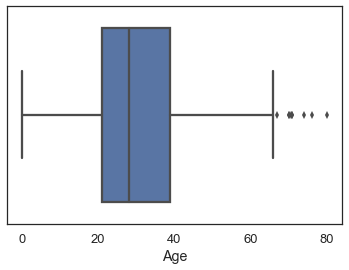

In [386]:
sns.boxplot(X[~X.Age.isnull()]['Age'])

In [387]:
size = len(X[X.Age.isnull()])
mean = X[~X.Age.isnull()]['Age'].mean()
std  = X[~X.Age.isnull()]['Age'].std()

print('Mean: {}; Std: {}'.format(mean, std))
print('Total NaN: {}'.format(size))

Mean: 29.8811376673; Std: 14.4134932113
Total NaN: 263


In [388]:
rdm_age = abs(np.random.randn(263)*std + mean) # Generating random number between the STD
rdm_age = rdm_age.reshape(-1, 1)
rdm_age[:5]

array([[ 29.18463319],
       [ 32.00777783],
       [ 46.69139595],
       [ 44.75499746],
       [ 21.32111531]])

In [389]:
X.loc[X[X.Age.isnull()].index, 'Age'] = rdm_age

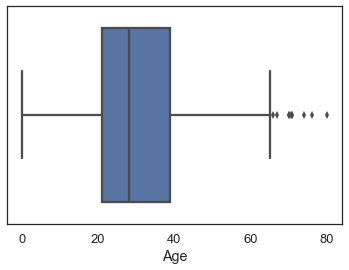

In [390]:
sns.boxplot(X[~X.Age.isnull()]['Age'])

Checking the distribution of the feature Age, we see that it didn't changed at all. <br />
Now we don't have any missing value, so we can move on.

---
### Handling some features
While loading the safeboats, the "women and children" were the protocol. So, might be useful to bin the Age in a *child/adult* category. <br />
Let's create a new feature with this in mind.

In [391]:
bins = [0, 18, max(X.Age)]
categories = [1, 0]
X['is_child'] = pd.cut(X.Age, bins, labels=categories)

The features "Sex" and "Embarked" could be one-hot-encoded in order to improve the performance of the classifier.

In [392]:
X = pd.concat([X, pd.get_dummies(X[['Sex', 'Embarked']])], axis=1)

In [393]:
del X['Sex']
del X['Age']
del X['Embarked']

The feature ticket is a string, so might be an issue while runing the classifier. <br />
So, let's just turn it into numbers.

In [399]:
ticket = {}
id = 0
for t in X.Ticket:
    if t not in ticket:
        ticket[t] = id
        id += 1

In [400]:
def get_id(s):
    return ticket[s]

In [402]:
X['ticket_id'] = X.Ticket.apply(get_id)

In [403]:
del X['Ticket']

Now let's check our dataset...

In [404]:
X.head()

,Pclass,SibSp,Parch,Fare,is_child,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,ticket_id
0,3,1,0,7.2500,0,0,1,0,0,1,0
1,1,1,0,71.2833,0,1,0,1,0,0,1
2,3,0,0,7.9250,0,1,0,0,0,1,2
3,1,1,0,53.1000,0,1,0,0,0,1,3
4,3,0,0,8.0500,0,0,1,0,0,1,4


In [466]:
from sklearn.preprocessing import MinMaxScaler

In [469]:
minmax = MinMaxScaler()

In [475]:
X['norm_fare'] = minmax.fit_transform(X.Fare.values.reshape(-1,1))

In [476]:
del X['Fare']



---
## Building the classifier

In [477]:
X_train, X_test = X[:891], X[891:]
print('train size: {0}; test size: {1}'.format(len(X_train), len(X_test)))

train size: 891; test size: 418


In [478]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [479]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y)

In [480]:
parameter_candidates = [
  {'n_estimators': [5, 10, 14, 15, 16, 20], 'criterion': ['gini', 'entropy'], \
   'random_state':[0], 'class_weight':['balanced', None], 'bootstrap':[True], \
   'oob_score':[True, False], 'min_samples_split':[2, 4, 6, 8], 'min_samples_leaf':[1, 2, 4, 6, 8], \
   'max_depth':[2, 4, 5, 6, 8, None], 'warm_start':[True, False]},

  {'n_estimators': [5, 10, 14, 15, 16, 20], 'criterion': ['gini', 'entropy'], \
   'random_state':[0], 'class_weight':['balanced', None], 'bootstrap':[False], \
   'min_samples_split':[2, 4, 6, 8], 'min_samples_leaf':[1, 2, 4, 6, 8], \
   'max_depth':[2, 4, 5, 6, 8, None],'warm_start':[True, False]}
]

In [481]:
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, n_jobs=-1, scoring=make_scorer(accuracy_score))

In [482]:
clf.fit(xtrain, ytrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 14, 15, 16, 20], 'warm_start': [True, False], 'oob_score': [True, False], 'random_state': [0], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8], 'bootstrap': [True], 'min_samples_leaf': [1, 2, 4, 6, 8], 'max_depth': [2, 4, 5, 6, 8, None], 'clas...les_leaf': [1, 2, 4, 6, 8], 'max_depth': [2, 4, 5, 6, 8, None], 'class_weight': ['balanced', None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [483]:
clf.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=True)

In [484]:
pred = clf.predict(xtest)

In [485]:
accuracy_score(y_pred=pred, y_true=ytest)

0.83856502242152464

In [446]:
accuracy_score(y_pred=pred, y_true=ytest)

0.81614349775784756

In [440]:
accuracy_score(y_pred=pred, y_true=ytest)

0.7623318385650224

In [463]:
passengerId = np.arange(892, 1310)

In [486]:
pred = clf.predict(X_test)

In [487]:
submission = pd.DataFrame({'PassengerId':passengerId, 'Survived':pred})
submission.to_csv("submission.csv", index=False)

teste = pd.read_csv('rf_mod_Solution.csv')

from sklearn.metrics import accuracy_score